# LiRa Shadow Models 160M

- 160M
- Smallish number of examples
- Per-example thresholding

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.6 MB/s eta 0:00:

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from transformers import Trainer, TrainingArguments
import pickle
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory / 1024**3
    r = torch.cuda.memory_reserved(0) / 1024**3
    a = torch.cuda.memory_allocated(0) / 1024**3
    print(f"Total Memory: {t:.2f} GB\n"
          f"Reserved Memory: {r:.2f} GB ({(100*(r/t)):.2f}%)\n"
          f"Remaining Memory: {t-r:.2f} GB ({(100*(t-r)/t):.2f}%)\n"
          f"---------------------------------\n"
          f"Allocated Memory: {a:.2f} GB ({(100*(a/t)):.2f}%)\n"
          f"Percent of Reserved Allocated: {(100*(a+1e-9)/(r+1e-9)):.2f}%\n")

In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Baby_v1_00") # Baby reviews a bit more distinctive than CPU

Generating train split:   0%|          | 0/1752932 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Baby_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Settings
small_string_filter = 20 # filters small strings 
dataset_division_constant = 2000
early_stop_patience = 2 # >= 1 (if val loss increases, runs early_stop_patience more epochs, then stops)

# Parameters
N = 12 # num_models (more doesn't necessarily help that much; I tried 16)
epochs = 12 # epochs to train (unless validation loss rises)
bs = 1
learn = 5e-5
mod_size = "160m"

In [5]:
# Deduping and getting rid of extremely short strings 
# TODO - maybe randomize this data? 
global_dataset = dataset["train"]['review_body'][:len(dataset["train"])//dataset_division_constant]
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset))
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset if len(entry) > small_string_filter))
print(f"Dataset Len: {len(global_dataset)}")

Dataset Len: 876
Dataset Len: 858
Dataset Len: 756


In [6]:
validation = dataset["train"]['review_body'][len(dataset["train"])//dataset_division_constant: 2*len(dataset["train"])//dataset_division_constant]
validation = list(set(entry for entry in validation if len(entry) > small_string_filter))

In [7]:
validation = validation[:len(validation) // 2]
print(len(validation))

378


# Data Creation

In [8]:
# Train until train loss = val loss
tokenizer = AutoTokenizer.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped")

In [9]:
def collate_fn(batch):
    global model
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": (tokens_padded > 0).clone().detach().to(dtype=torch.int)
    }

In [10]:
def arr_split(chunks, N):
    if N % 2 != 0:
        print("Need even N!")
        return []
    lists = [[] for i in range(N)]

    for i in range(N):
        for j in range(i, int(i + N/2)):
            lists[i] += chunks[j % N]

    return lists

In [11]:
def orthogonal_chunk(i):
    return int(N/2 + i) % N

In [12]:
data_chunks = [global_dataset[i * len(global_dataset)//N : (i+1) * len(global_dataset) // N] for i in range(N)]

In [13]:
data_arr = arr_split(data_chunks, N)

In [14]:
len(data_arr[0])

378

# Fine Tune Method

In [15]:
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
    model = model.to(device)
    model.config.use_cache = False
    training_args = TrainingArguments(output_dir="fine-tuning",
                                    do_train=True,
                                    do_eval=True,
                                    num_train_epochs=epochs,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    evaluation_strategy="epoch",
                                    logging_strategy="epoch",
                                    save_strategy="epoch",
                                    gradient_accumulation_steps=1,
                                    gradient_checkpointing=False,
                                    load_best_model_at_end = True,
                                    optim="adafactor",
                                    )
    trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    callbacks=[EarlyStoppingCallback(early_stop_patience, 0.0)] # if val loss improve for >1 iterations, end. 
                  )
    trainer.train()
    return model

# Base Model (to be attacked)

In [16]:
# Fine tune a model on the first 6 chunks of data

from transformers import EarlyStoppingCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device)
train(model, data_arr[0], data_arr[orthogonal_chunk(0)], collate_fn, bs, epochs)
model.save_pretrained("lira_large/pythia-160m", from_pt=True) 
del model
torch.cuda.empty_cache()

cuda


Epoch,Training Loss,Validation Loss
1,5.170500,5.036335
2,3.547900,5.340625
3,2.616100,5.668697


# Shadow Models

In [17]:
for i in range(N):
    print(f"Model #{i}")
    model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device)
    mem_stats()
    model = train(model, data_arr[i], data_arr[orthogonal_chunk(i)], collate_fn, bs, epochs)
    model.save_pretrained(f"lira_large/pythia-160m-shadow-{i}", from_pt=True) 
    del model
    torch.cuda.empty_cache()
    mem_stats()

Model #0
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.170500,5.036335
2,3.547900,5.340625
3,2.616100,5.668697


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #1
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.122800,5.085017
2,3.422600,5.387441
3,2.434100,6.031162


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #2
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.060800,5.253999
2,3.419100,5.279149
3,2.477700,6.179035


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #3
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.083400,5.638790
2,3.556100,5.534622
3,2.617400,5.928367
4,2.002400,6.277709


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #4
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.104600,5.023459
2,3.440300,5.265110
3,2.462400,5.894045


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #5
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.228900,5.166867
2,3.586600,5.414145
3,2.594400,5.859057


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #6
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.187900,5.254761
2,3.599500,5.616127
3,2.691400,5.955880


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.02 GB (0.11%)
Percent of Reserved Allocated: 2.26%

Model #7
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.238100,5.144316
2,3.557100,5.423065
3,2.863100,6.003683


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #8
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.278400,5.101825
2,3.571600,5.420762
3,2.575700,5.923401


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #9
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.228000,5.020736
2,3.537900,5.349066
3,2.575500,5.906054


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #10
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.163300,5.049865
2,3.453900,5.495611
3,2.479200,6.103621


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%

Model #11
Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



Epoch,Training Loss,Validation Loss
1,5.166700,5.046176
2,3.558600,5.362937
3,2.582300,5.823002


Total Memory: 14.75 GB
Reserved Memory: 0.70 GB (4.75%)
Remaining Memory: 14.05 GB (95.25%)
---------------------------------
Allocated Memory: 0.67 GB (4.56%)
Percent of Reserved Allocated: 95.82%



# Evaluation

In [18]:
def get_in_models(chunk_no, N):
    """
    Returns a list of models that should be used for inference for a given chunk
    """
    ins = []
    outs = []
    for i in range(N):
        lower = i
        upper = int(i+N/2)
        innit = False
        for j in range(lower, upper):
            if chunk_no == j % N:
                innit = True
        if innit:
            ins.append(i)
        else:
            outs.append(i)
    return (ins, outs)

In [19]:
from torch.nn import CrossEntropyLoss
import math

def compute_ce_loss(model, tokenizer, string):
    input_ids = tokenizer.encode(string, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    loss_fn = CrossEntropyLoss()
    input_len = input_ids.shape[-1] - 1
    input_ids_without_first_token = input_ids[:, 1:]
    logits_without_last_token = logits[:, :-1, :]
    loss = loss_fn(logits_without_last_token.view(-1, logits.size(-1)), input_ids_without_first_token.view(-1))
    return loss

def compute_confidence(ce_loss):
    conf = math.exp(-1 * ce_loss)
    return math.log(conf / (1-conf))

In [20]:
all_arr = [f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)]
# modelsarr = [GPTNeoXForCausalLM.from_pretrained(path) for path in all_arr]

# New

In [21]:
def chunks_this_model(mid):
  # Get chunks w/ this model ID
  inc = []
  outc = []
  for i in range(mid, mid+6):
    inc.append((i) % 12)
  for i in range(N):
    if i not in inc:
      outc.append(i)
  return (inc, outc)

In [22]:
# Briefly, this is what this method does:
# Because it's too time consuming to load models in and out of memory, and not enough RAM to keep all of them there, it loads in one model at a time, does all evaluations
# for that model, and continues. 
# initializes an array for every data point that contains an array of confidences for IN, OUT, and then target CONF. Only compute target CONF when that example has never been seen before. 

# Load a model into GPU RAM
example_data = [[] for i in range(len(data_chunks))]
all_arr = [f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)]
target_model = GPTNeoXForCausalLM.from_pretrained(f"./lira_large/pythia-160m").to(device)

# Run all points on it
for i, path in enumerate(all_arr):
  print(f"Loading {i}")
  t_model = GPTNeoXForCausalLM.from_pretrained(path).to(device)
  # Get chunks
  inc, outc = chunks_this_model(i)

  for c in inc:
    print(f" - {c}")
    if len(example_data[c]) == 0:
      for example in data_chunks[c]:
        # IN MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)

        # TARGET
        target_ce_loss = compute_ce_loss(target_model, tokenizer, example)
        targ_conf = compute_confidence(ce_loss)
        example_data[c].append([[conf], [], targ_conf])
    else:
      for i, example in enumerate(data_chunks[c]):
        # IN MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)
        example_data[c][i][0].append(conf)
  
  for c in outc:
    print(f" - {c}")
    if len(example_data[c]) == 0:
      for example in data_chunks[c]:
        # OUT MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)

        # TARGET
        target_ce_loss = compute_ce_loss(target_model, tokenizer, example)
        targ_conf = compute_confidence(ce_loss)
        example_data[c].append([[], [conf], targ_conf])
    else:
      for i, example in enumerate(data_chunks[c]):
        # OUT MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)
        example_data[c][i][1].append(conf)

  del t_model
  torch.cuda.empty_cache()

Loading 0
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
 - 10
 - 11
Loading 1
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 0
 - 7
 - 8
 - 9
 - 10
 - 11
Loading 2
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
Loading 3
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 0
 - 1
 - 2
 - 9
 - 10
 - 11
Loading 4
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
 - 0
 - 1
 - 2
 - 3
 - 10
 - 11
Loading 5
 - 5
 - 6
 - 7
 - 8
 - 9
 - 10
 - 0
 - 1
 - 2
 - 3
 - 4
 - 11
Loading 6
 - 6
 - 7
 - 8
 - 9
 - 10
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
Loading 7
 - 7
 - 8
 - 9
 - 10
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
Loading 8
 - 8
 - 9
 - 10
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
Loading 9
 - 9
 - 10
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
Loading 10
 - 10
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
Loading 11
 - 11
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
 - 10


In [24]:
from scipy import stats

results = []

for c in example_data:
  for e, i in enumerate(c):
    mu_target = i[2]
    mu_in = np.mean(i[0])
    std_in = np.std(i[0])
    mu_out = np.mean(i[1])
    std_out = np.std(i[1])

    likelihood_in = stats.norm.pdf(mu_target, mu_in, std_in)
    likelihood_out = stats.norm.pdf(mu_target, mu_out, std_out)
    lira = likelihood_in / likelihood_out
    in_true_model = e >= 0 and e < N/2
    results.append((likelihood_in,likelihood_out,lira,in_true_model))

with open("./lira_large/lira.pickle","wb") as f:
    pickle.dump(results,f)

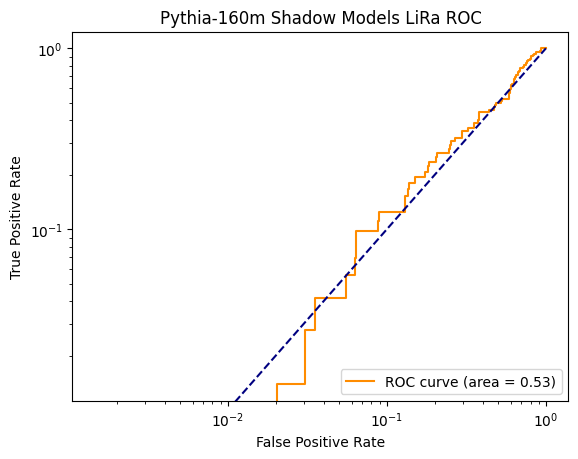

In [25]:
with open("./lira_large/lira.pickle","rb") as f:
    results = pickle.load(f)
# Generate ROC curve 
fpr, tpr, thresholds = roc_curve([int(result[3]) for result in results], [result[2] for result in results])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Shadow Models LiRa ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Old

In [ ]:
import random
import scipy.stats as stats

def conf_nums(paths, ins, exs, tokenizer):
    confs = []
    for i, path in enumerate(paths):
        model = GPTNeoXForCausalLM.from_pretrained(path).to(device)
        if i in ins:
            for ex in exs:
                ce_loss = compute_ce_loss(model, tokenizer, ex)
                confs.append(compute_confidence(ce_loss))
        del model
        torch.cuda.empty_cache()
    return (np.mean(confs), np.std(confs))

In [ ]:
# Over examples
results = []
for i, chunk in enumerate(data_chunks):
    print(f"Processing Chunk {i}...")
    ins, outs = get_in_models(i, N)

    # Get IN Mu/Stdev
    mu_in, std_in = conf_nums([f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)], ins, chunk, tokenizer)

    # Get OUT Mu/Stdev
    mu_out, std_out = conf_nums([f"./lira_large/pythia-160m-shadow-{i}" for i in range(N)], outs, chunk, tokenizer)

    # Get TARGET Mu
    mu_target, std_target = conf_nums([f"./lira_large/pythia-160m"], [0], chunk, tokenizer)

    likelihood_in = stats.norm.pdf(mu_target, mu_in, std_in)
    likelihood_out = stats.norm.pdf(mu_target, mu_out, std_out)
    lira = likelihood_in / likelihood_out
    in_true_model = i >= 0 and i < N/2
    results.append((likelihood_in,likelihood_out,lira,in_true_model))
    print(f"Likelihood In: {likelihood_in}\n"
        f"Likelihood Out: {likelihood_out}\n"
        f"LiRa: {lira}\n"
        f"In True Mode: {in_true_model}\n")
    
with open("./lira_large/lira.pickle","wb") as f:
    pickle.dump(results,f)

In [ ]:
with open("./lira_large/lira.pickle","rb") as f:
    results = pickle.load(f)
# Generate ROC curve 
fpr, tpr, thresholds = roc_curve([int(result[3]) for result in results], [result[2] for result in results])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Shadow Models LiRa ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()